In [11]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os
import sys
import plotly.graph_objects as go 
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')
from labbiofisica import Interpolazione, final_val
from scipy.optimize import curve_fit

In [12]:
filename = 'data/stokes_shift_05.csv'
data = pd.read_csv(filename, sep=',',header=1,nrows=151)
# Drop the 'Unnamed: 4' column as it contains no useful data
data = data.drop(columns=['Unnamed: 4'])
data.tail()

,Wavelength (nm),Intensity (a.u.),Wavelength (nm).1,Intensity (a.u.).1
146,NaN,NaN,545.969971,420.667816
147,NaN,NaN,547.010010,377.603302
148,NaN,NaN,548.049988,338.718384
149,NaN,NaN,548.950012,303.112579
150,NaN,NaN,550.000000,268.755066


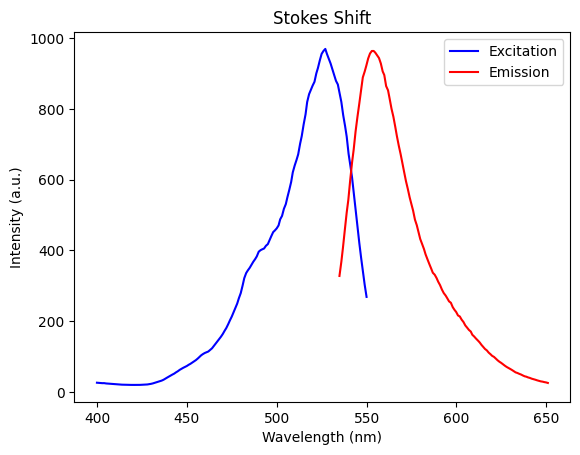

In [13]:
ecc_lambda = data['Wavelength (nm).1'].dropna().to_numpy()
ecc_int = data['Intensity (a.u.).1'].dropna().to_numpy()

emi_lambda = data['Wavelength (nm)'].dropna().to_numpy()
emi_int = data['Intensity (a.u.)'].dropna().to_numpy()

plt.plot(ecc_lambda, ecc_int, label='Excitation', color='blue')
plt.plot(emi_lambda, emi_int, label='Emission', color='red')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.title('Stokes Shift')
plt.legend()
plt.show()


In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ecc_lambda, y=ecc_int,
                    mode='lines+markers',
                    name='Excitation'))
fig.add_trace(go.Scatter(x=emi_lambda, y=emi_int,
                    mode='lines+markers',
                    name='Emission'))

fig.update_layout(title='Stokes Shift',
                  xaxis_title='Wavelength (nm)',
                  yaxis_title='Intensity (a.u.)',
                  legend=dict(x=0.1, y=0.9),
                  font=dict(size=14))


fig.show()

fit parabolico nei picchi:

In [15]:
def parabola(x, x0,y0,a): # a positivo per picchi
    return y0 - a*(x-x0)**2

In [16]:
max_index_ecc_int = np.argmax(ecc_int)
max_index_emi_int = np.argmax(emi_int)

d = 5
y = ecc_int[max_index_ecc_int-d:max_index_ecc_int+d]
x = ecc_lambda[max_index_ecc_int-d:max_index_ecc_int+d]
guess = [ecc_lambda[max_index_ecc_int], ecc_int[max_index_ecc_int], 2]
popt_ecc, pcov_ecc = curve_fit(parabola, x, y, p0=guess)
error_ecc = np.sqrt(np.diag(pcov_ecc))
res = dict(zip(['λecc', 'y0', 'a'], popt_ecc))
print(res)

y = emi_int[max_index_emi_int-d:max_index_emi_int+d]
x = emi_lambda[max_index_emi_int-d:max_index_emi_int+d]
guess = [emi_lambda[max_index_emi_int], emi_int[max_index_emi_int], 2]
popt_emi, pcov_emi = curve_fit(parabola, x, y, p0=guess)
error_emi = np.sqrt(np.diag(pcov_emi))
res = dict(zip(['λemi', 'y0', 'a'], popt_emi))
print(res)

{'λecc': np.float64(526.7262183571453), 'y0': np.float64(962.5851001628981), 'a': np.float64(2.9899249405064463)}
{'λemi': np.float64(553.9488401255329), 'y0': np.float64(963.4038264423648), 'a': np.float64(2.3253309574751326)}


In [17]:
# STOKE SHIFT
delta_lambda = np.abs(popt_ecc[0] - popt_emi[0])
sigma_delta_lambda = np.sqrt(error_ecc[0]**2 + error_emi[0]**2)
print('Δλ: ', final_val(delta_lambda, sigma_delta_lambda,1,udm='nm'))
stokes_shift = 1240/popt_ecc[0] - 1240/popt_emi[0]
sigma_delta_lambda = np.sqrt((1240/popt_ecc[0]**2 * error_ecc[0])**2 + (1240/popt_emi[0]**2 * error_emi[0])**2)
print('ΔE: ', final_val(stokes_shift, sigma_delta_lambda,4,udm='eV'))

Δλ:  27.2 ± 0.1 nm
ΔE:  0.1157 ± 0.0005 eV


In [18]:
x_ecc = np.linspace(ecc_lambda[max_index_ecc_int-d], ecc_lambda[max_index_ecc_int+d], 1000)
y_ecc = parabola(x_ecc, *popt_ecc)

x_emi = np.linspace(emi_lambda[max_index_emi_int-d], emi_lambda[max_index_emi_int+d], 1000)
y_emi = parabola(x_emi, *popt_emi)

fig = go.Figure()
fig.add_trace(go.Scatter(x=ecc_lambda, y=ecc_int,
                    mode='lines+markers',
                    name='Excitation'))
fig.add_trace(go.Scatter(x=emi_lambda, y=emi_int,
                    mode='lines+markers',
                    name='Emission'))

fig.add_trace(go.Scatter(x=x_ecc, y=y_ecc,
                    mode='lines',
                    name='Excitation Fit',
                    line=dict(color='blue', width=5)))

fig.add_trace(go.Scatter(x=x_emi, y=y_emi,
                    mode='lines',
                    name='Emission Fit',
                    line=dict(color='red', width=5)))

fig.add_shape(
    type="rect",
    x0=ecc_lambda[max_index_ecc_int], x1=emi_lambda[max_index_emi_int],
    y0=0, y1=1000,
    fillcolor="green",
    opacity=0.3,
    layer="below",
    line_width=0,
)

# fig.add_shape(
#     type="line",
#     x0=ecc_lambda[max_index_ecc_int], x1=ecc_lambda[max_index_ecc_int],
#     y0=0, y1=np.max(y_ecc),
#     line=dict(color="blue", width=2, dash="dash"),
# )

# fig.add_shape(
#     type="line",
#     x0=emi_lambda[max_index_emi_int], x1=emi_lambda[max_index_emi_int],
#     y0=0, y1=np.max(y_emi),
#     line=dict(color="red", width=2, dash="dash"),
# )


fig.update_layout(
                  xaxis_title='Wavelength (nm)',
                  yaxis_title='Intensity (a.u.)',
                  height=600,
                  width=800,
                  yaxis=dict(range=[0, 1000]),
                  legend=dict(x=0.1, y=0.9),
                  font=dict(size=14))


fig.show()